In [24]:
%matplotlib inline
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from importlib import reload

import vip_hci as vip
from hciplot import plot_frames, plot_cubes

from vip_hci.config import VLT_NACO
from vip_hci.fm import normalize_psf, cube_inject_companions
from vip_hci.psfsub import median_sub, pca, pca_annular, pca_annulus

from vip_hci.fits import open_fits, write_fits, info_fits
from vip_hci.metrics import significance, snr, snrmap
from vip_hci.var import fit_2dgaussian, frame_center

from vip_hci.preproc.cosmetics import cube_crop_frames, frame_crop

In [63]:
import training_set_generation_functions
reload(training_set_generation_functions)
from training_set_generation_functions import inject_random_fake_comp, make_mlar_plus, get_fwhm, evaluate_snr


In [3]:
adi=np.load('adi_seq.npy')
pa=np.load('pa.npy')
psf=np.load('psf.npy')
pxscale=np.load('pxscale.npy')

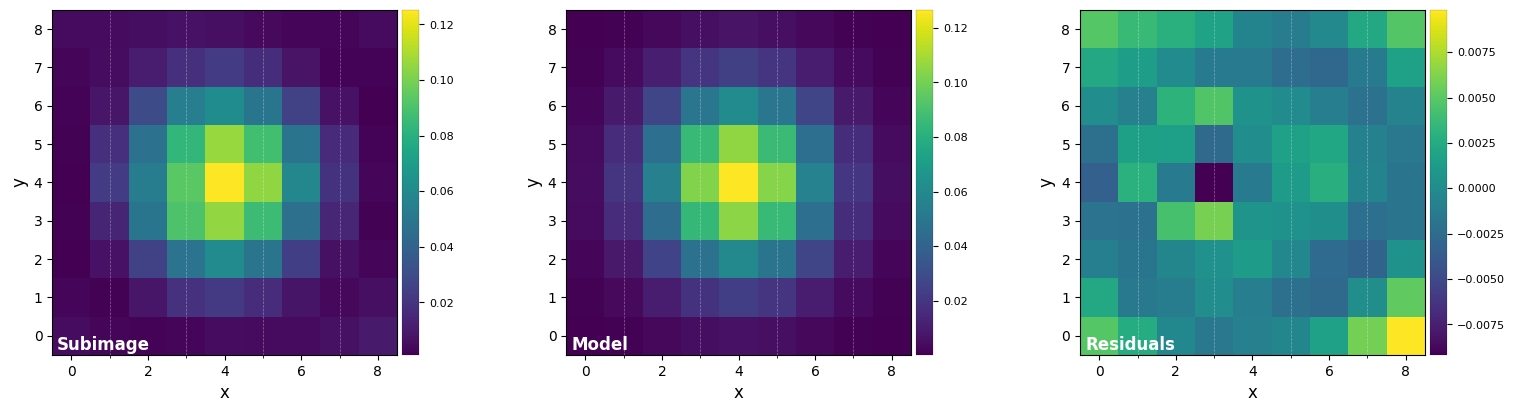

FWHM_y = 3.8683973545822607
FWHM_x = 3.6684473919771023 

centroid y = 20.01540679237611
centroid x = 20.010679376110478
centroid y subim = 4.015406792376109
centroid x subim = 4.010679376110477 

amplitude = 0.12659284517153813
theta = 3.777210099096072
Flux in 1xFWHM aperture: 0.994
flux :1179
New shape: (9, 9)
New shape: (9, 9)
New shape: (9, 9)
New shape: (9, 9)
New shape: (9, 9)
PA threshold 15.12 is likely too big, will be set to 14.19
in_posxy :(83.76842237327968, 80.0)
sourcexy :(83.76842237327968, 80.0)
snr_vale :3.5694551730910624
f_source :103.15747711727687


In [64]:
fwhm = get_fwhm(psf)
an_radius = 1*fwhm
adi_with_fake_comp, inj_posxy = inject_random_fake_comp(adi, psf, pxscale, pa, fwhm, an_radius)
mlar=make_mlar_plus(adi_with_fake_comp, 5, pa, fwhm, inj_posxy, an_radius, plot=False)
snr_vale, f_source, sourcexy = evaluate_snr(adi_with_fake_comp, pa, fwhm, inj_posxy, an_radius)

print('in_posxy :'+str(inj_posxy))
print('sourcexy :'+str(sourcexy))
print('snr_vale :'+str(snr_vale))
print('f_source :'+str(f_source))

In [42]:
help(snr)

Help on function snr in module vip_hci.metrics.snr_source:

snr(array, source_xy, fwhm, full_output=False, array2=None, use2alone=False, exclude_negative_lobes=False, plot=False, verbose=False)
    Calculate the S/N (signal to noise ratio) of a test resolution element
    in a residual frame (e.g. post-processed with LOCI, PCA, etc). Implements
    the approach described in [MAW14]_ on small sample statistics,
    where a student t-test (eq. 9) can be used to determine S/N (and contrast)
    in high contrast imaging. 3 extra possibilities compared to [MAW14]_:
    
        * possibility to provide a second array (e.g. obtained with opposite         derotation angles) to have more apertures for noise estimation;
    
        * possibility to exclude negative ADI lobes directly adjacent to the         tested xy location, to not bias the noise estimate;
    
        * possibility to use only the second array for the noise estimation         (useful for images containing a lot of disk/exte

# C+ patch generation
## injecting a fake companion in 1 adi cube

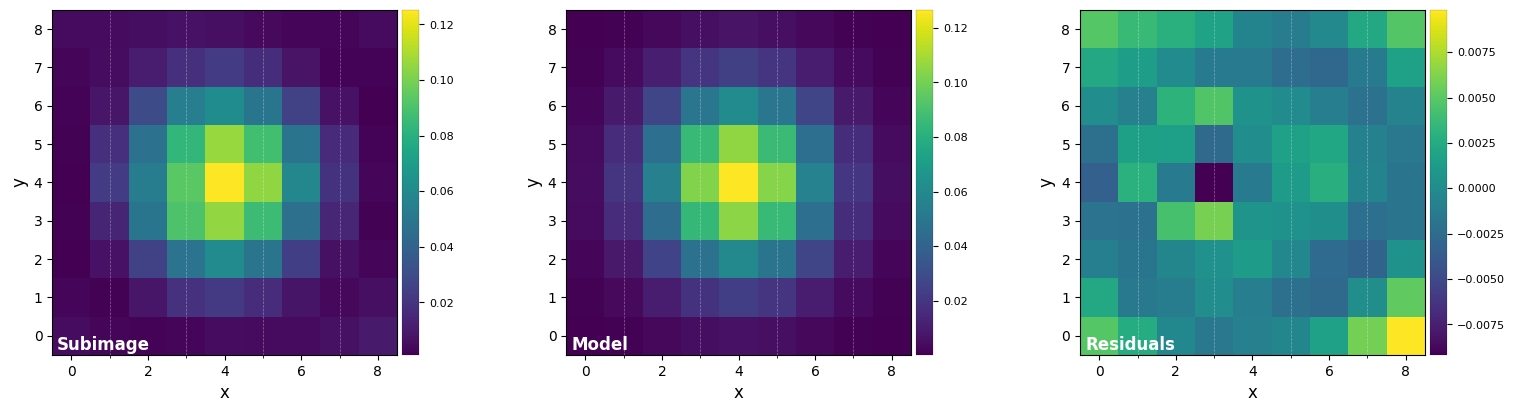

FWHM_y = 3.8683973545822607
FWHM_x = 3.6684473919771023 

centroid y = 20.01540679237611
centroid x = 20.010679376110478
centroid y subim = 4.015406792376109
centroid x subim = 4.010679376110477 

amplitude = 0.12659284517153813
theta = 3.777210099096072


In [3]:
DF_fit = fit_2dgaussian(psf, crop=True, cropsize=9, debug=True, full_output=True)
fwhm = np.mean([DF_fit['fwhm_x'],DF_fit['fwhm_y']])   #using gaussian fit to get FWHM

Evaluating flux interval corresponding to a S/N interval of [1,3]

In [49]:
adi_pca = pca_annular(adi, pa, ncomp=5, imlib='skimage', interpolation='bicubic',svd_mode='lapack', verbose=False)
snrmap_1 = snrmap(adi_pca, fwhm=fwhm, plot=False)
bnd_1 = np.unravel_index(np.argmin(abs(snrmap_1 - 1), axis=None), snrmap_1.shape)
bnd_2 = np.unravel_index(np.argmin(abs(snrmap_1 - 3), axis=None), snrmap_1.shape)
flux_min = adi_pca[bnd_1]
flux_max = adi_pca[bnd_2]
print(flux_min)
print(flux_max)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-11-05 15:26:08
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 2 processes
Running time:  0:01:16.472943
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
0.24674606
5.652321


In [ ]:
    an_radius= fwhm
    rot_options={'imlib':'skimage', 'interpolation':'bicubic'}
    adi_pca = pca_annulus(adi_with_fake_comp, pa, ncomp, 2*fwhm,an_radius , cube_ref=None, svd_mode='lapack', scaling=None, collapse='median', weights=None, collapse_ifs='mean', **rot_options)
    snr(adi_pca)

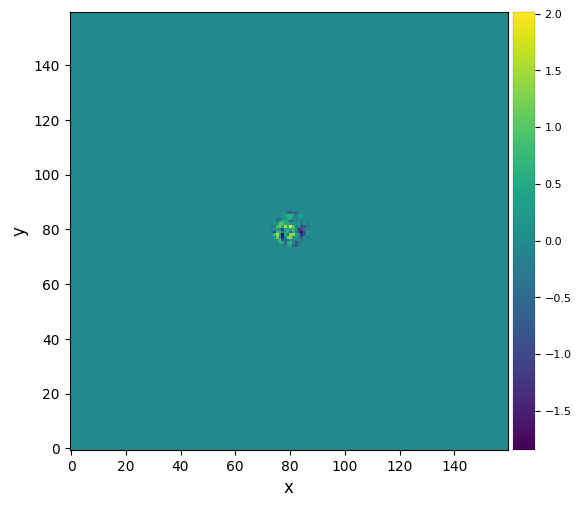

In [72]:
ncomp=5
an_radius= fwhm
rot_options={'imlib':'skimage', 'interpolation':'bicubic'}
adi_pca = pca_annulus(adi, pa, ncomp, 2*fwhm,an_radius , cube_ref=None, svd_mode='lapack', scaling=None, collapse='median', weights=None, collapse_ifs='mean', **rot_options)
plot_frames(adi_pca)

Here the fake companion is injected at r= 5*fwhm (being the centre of the annulus having an inside diametre of $\approx 5 \lambda/D$ and 0° angle with a flux equal to (flux_min+flux_max)/2 corresponding to the arithmetic mean of the the fluxes leading to a S/N $\in$ [1,3] (as computed above)

In [77]:
norm_psf = normalize_psf(psf, fwhm=fwhm, model='gauss', imlib='opencv', interpolation='bicubic')       #Normalizing PSF
adi_with_fake_comp, inj_posyx = cube_inject_companions(adi, psf, pa, flevel= 100, plsc=pxscale, rad_dists=1*fwhm, theta=0, imlib='opencv', interpolation='bicubic', full_output=True)
inj_posyx=inj_posyx[0]
inj_posxy=(inj_posyx[1], inj_posyx[0])

Flux in 1xFWHM aperture: 0.994


Now generating one MLAR patch using 5 principal components

In [78]:
ncomp=5
patch_width = np.ceil(2*fwhm) // 2 * 2 + 1    # rounding to the nearest odd integer
patch_width = int(patch_width)

MLAR_patch_plus=[]

for i in range(1, ncomp+1):
    an_radius= fwhm
    rot_options={'imlib':'skimage', 'interpolation':'bicubic'}
    adi_pca = pca_annulus(adi_with_fake_comp, pa, ncomp, 2*fwhm,an_radius , cube_ref=None, svd_mode='lapack', scaling=None, collapse='median', weights=None, collapse_ifs='mean', **rot_options)
    MLAR_patch_plus.append(vip.preproc.cosmetics.frame_crop(adi_with_fake_comp_pca, patch_width, cenxy=inj_posxy, force=True))
    
    #adi_with_fake_comp_pca = pca_annular(adi_with_fake_comp, pa, fwhm=fwhm, ncomp=i+1, svd_mode='lapack', imlib='skimage', interpolation='bicubic', verbose=False)
    

New shape: (9, 9)
New shape: (9, 9)
New shape: (9, 9)
New shape: (9, 9)
New shape: (9, 9)


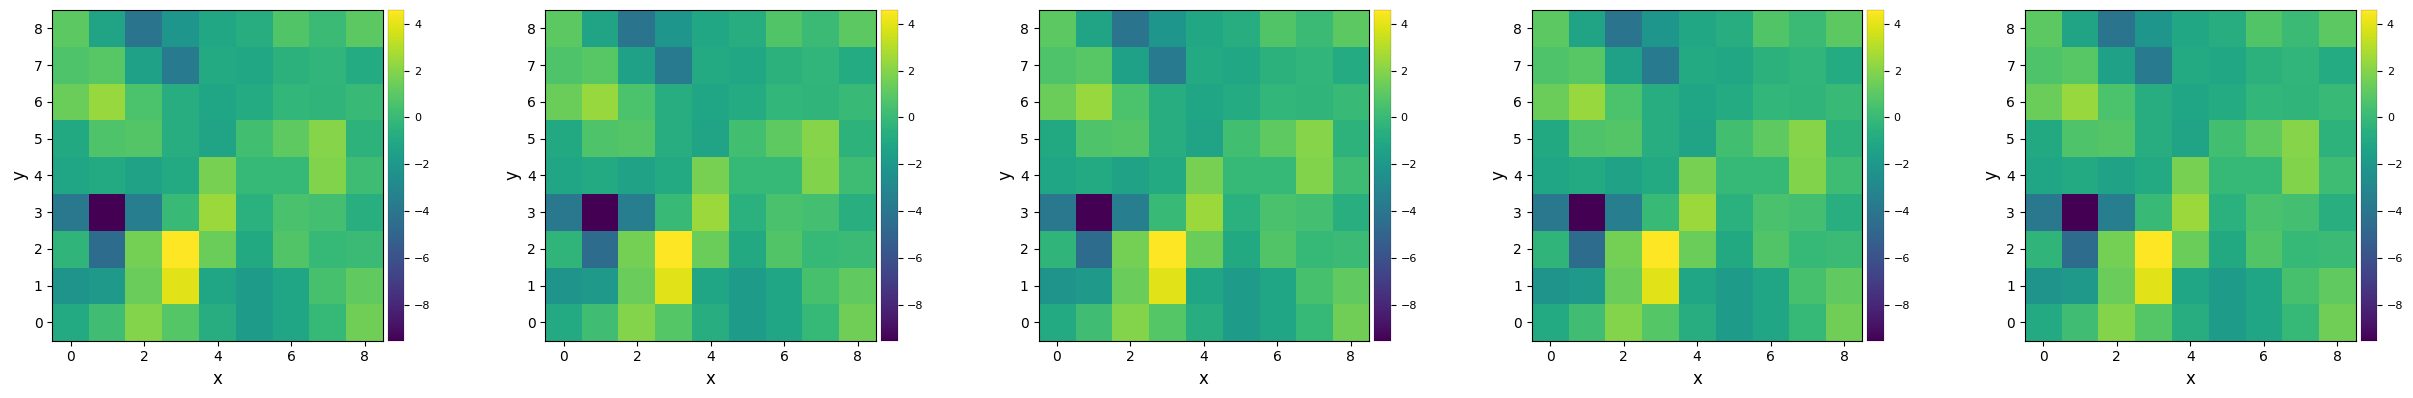

In [79]:
plot_frames(tuple(MLAR_patch_plus[i] for i in range(ncomp)))

# C- patch generation

Generating a cube of residuals

In [31]:
res_cube=[]
ncomp=5
for i in range(1,ncomp+1):
    res_cube.append(pca_annular(adi, pa, ncomp=i, fwhm=fwhm, asize=fwhm, imlib='skimage', interpolation='bicubic',svd_mode='lapack', verbose=False))
res_cube=np.array(res_cube)

Exctracting random noise patches around circle with $6*\lambda/D$ radius

In [32]:
def random_point_circle(radius, tol, xy_centre):
    """Generate random distribution of points around a circle centred on tuple (x,y) of radius r
    Within tolerance tol, i.e. radius of the position (in polar coordinates) maybe lie in [r - tol, r + tol] """
    
    r = np.random.randint(radius-tol, high=radius+tol)
    theta = np.random.randint(0, high=2*np.pi)
    
    x= r*np.cos(theta) + xy_centre[0]
    y= r*np.sin(theta) + xy_centre[1]
    
    return (x,y)

In [38]:
MLAR_patch_min=[]
centre_coord=[]
patch_nbr=200

xy_centre=(adi[0].shape[0]/2,adi[0].shape[1]/2)

for i in range(patch_nbr):
    rand_x, rand_y = random_point_circle(6*fwhm, fwhm, xy_centre)
    centre_coord.append((rand_x, rand_y))
    
for i in range(patch_nbr):
    MLAR_patch_min.append(cube_crop_frames(res_cube, patch_width, xy=centre_coord[i], force=True, verbose=False))

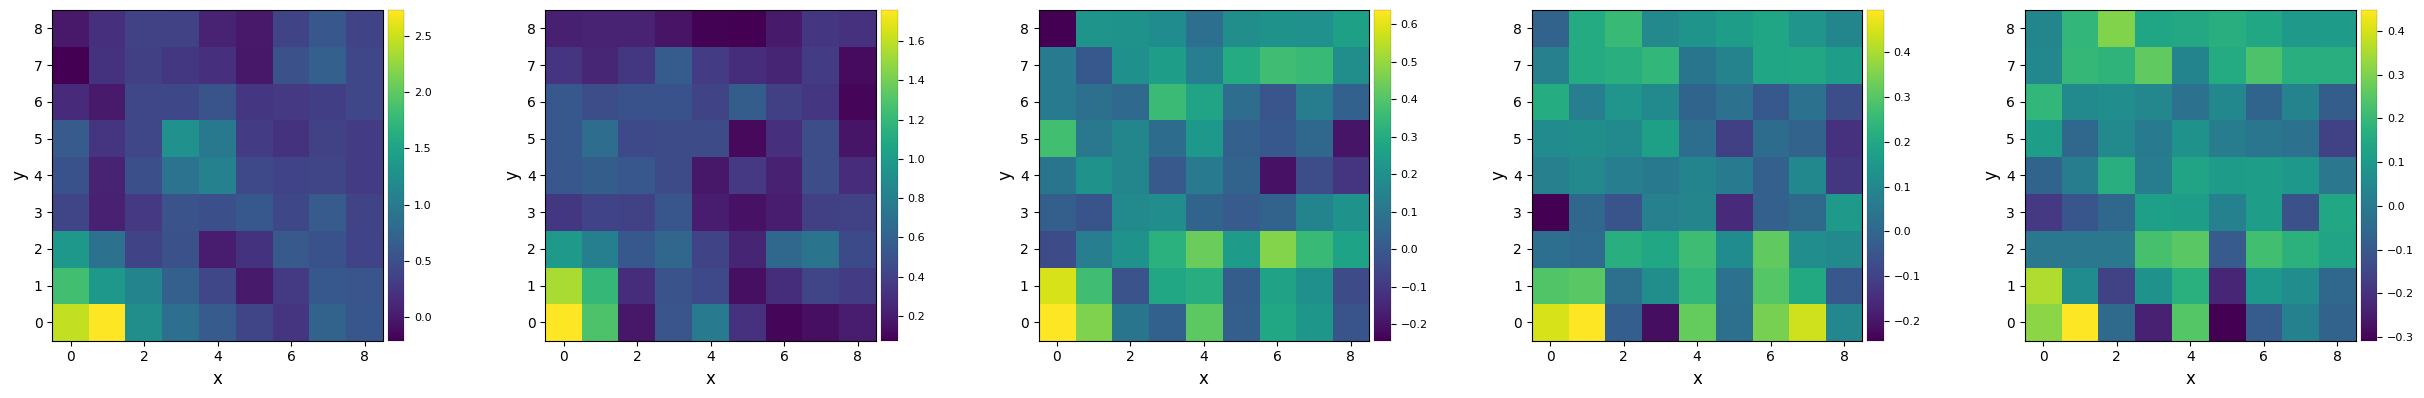

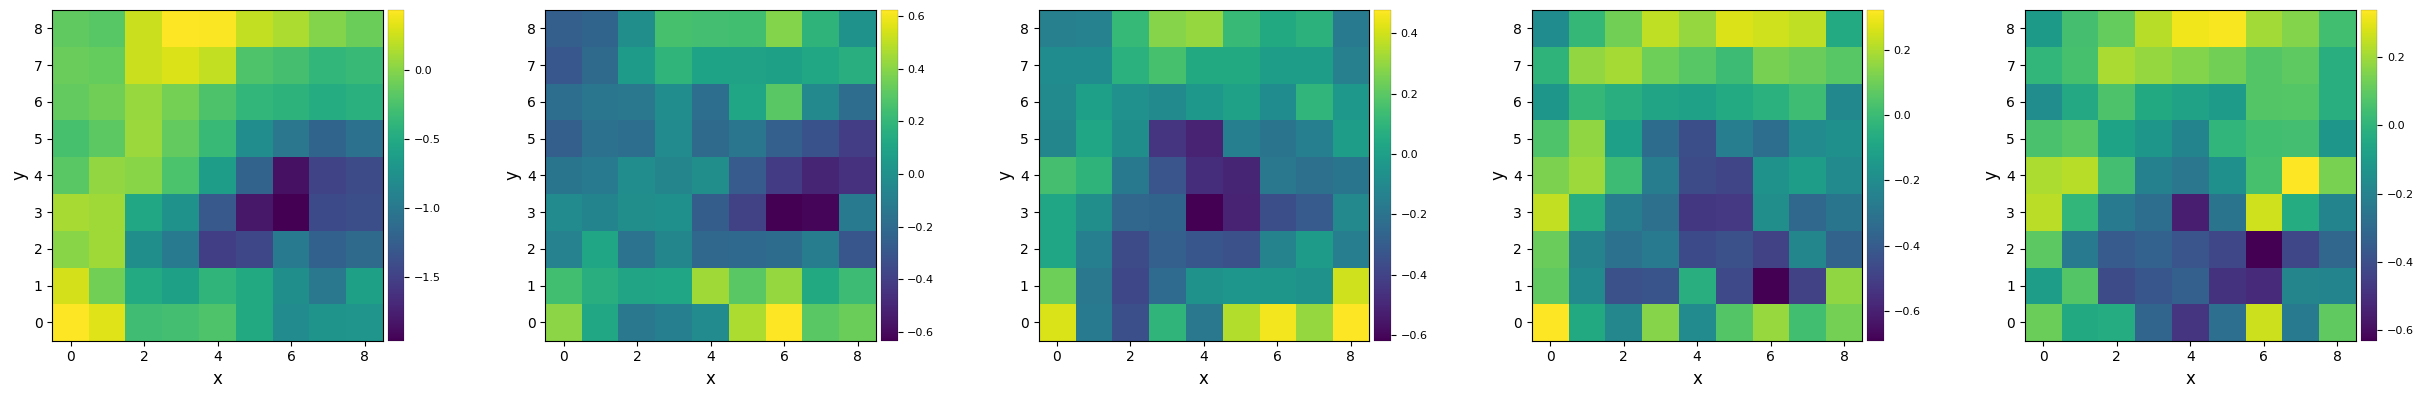

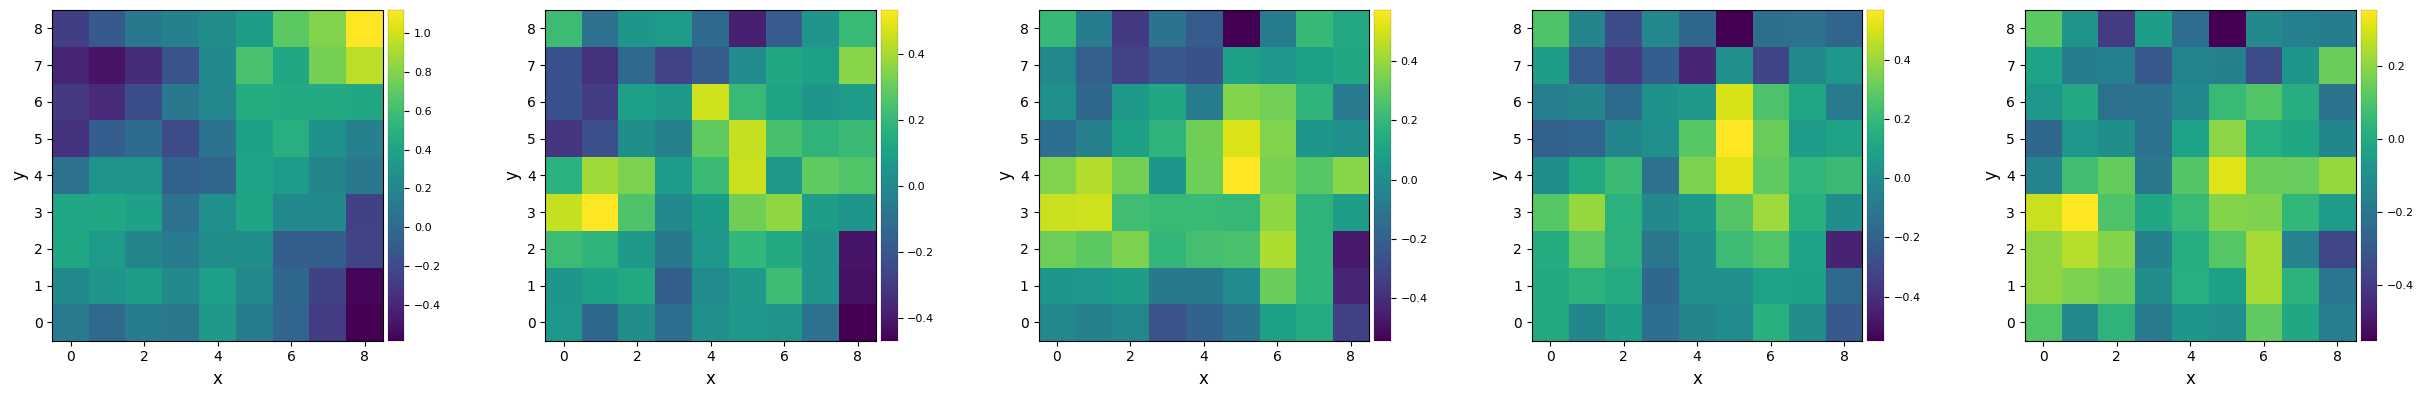

In [39]:
plot_frames(tuple(MLAR_patch_min[0][i] for i in range(ncomp)))
plot_frames(tuple(MLAR_patch_min[1][i] for i in range(ncomp)))
plot_frames(tuple(MLAR_patch_min[2][i] for i in range(ncomp)))

In [64]:
help(vip.psfsub.utils_pca)

Help on module vip_hci.psfsub.utils_pca in vip_hci.psfsub:

NAME
    vip_hci.psfsub.utils_pca - Module with helping functions for PCA.

FUNCTIONS
    pca_annulus(cube, angs, ncomp, annulus_width, r_guess, cube_ref=None, svd_mode='lapack', scaling=None, collapse='median', weights=None, collapse_ifs='mean', **rot_options)
        PCA-ADI or PCA-RDI processed only for an annulus of the cube, with a given
        width and at a given radial distance to the frame center. It returns a
        processed frame with non-zero values only at the location of the annulus.
        
        Parameters
        ----------
        cube : 3d or 4d numpy ndarray
            Input data cube to be processed by PCA.
        angs : numpy ndarray or None
            The parallactic angles expressed as a numpy.array.
        ncomp : int or list/1d numpy array of int
            The number of principal component.
        annulus_width : float
            The annulus width in pixel on which the PCA is performed.
